# code to create fig2d, 2e, 2f, 2g

## Set up

In [9]:
quiet_library <- function(...) {
    suppressPackageStartupMessages(library(...))
}
quiet_library(Seurat)
quiet_library(tidyverse)
quiet_library(viridis)
quiet_library(data.table)
quiet_library(future)

In [10]:
# load costomized helper functions
# source('/home/jupyter/github/Teaseq-analysis/scRNA_teaseq_ananlysis_helper_functions.r')

In [11]:
# set up parallel processing if wanted
# Check number of cores
# options("mc.cores" = 63)
future::availableCores()
# Set up parallel processing to run when using 'future' functions 
future::plan(strategy = "multicore", workers = future::availableCores()-3)  
options(future.globals.maxSize = 1000 * 1024^5)
# to turn off parallel processing run line below
# future::plan(strategy = "sequential")

system 
    64

In [12]:
# define file path
fig_path <- as.character('/home/jupyter/figures/PedvsSenior/manuscript')
data_path <- '/home/jupyter/data/PedvsSenior'
output_path <- '/home/jupyter/data/PedvsSenior/output_results/mixed_model'
# define a project name
proj_name <- 'Teaseq_PedvsSenior'
if(!dir.exists(fig_path)) (dir.create(fig_path, recursive = TRUE))
if(!dir.exists(output_path)) (dir.create(output_path, recursive = TRUE))

In [13]:
# define the color palette to be used
npg_color <- c("#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", 
               "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF")
nejm_color <- c("#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF", "#7876B1FF", "#6F99ADFF", "#FFDC91FF", "#EE4C97FF")
jama_color <- c("#374E55FF", "#DF8F44FF", "#00A1D5FF", "#B24745FF", "#79AF97FF", "#6A6599FF", "#80796BFF")
jco_color <- c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF", "#8F7700FF")
cluster_colors <- c("#DC050C", "#FB8072", "#1965B0", "#7BAFDE", "#882E72", "#B17BA6", "#FF7F00", "#FDB462", "#E7298A", 
    "#E78AC3", "#33A02C", "#B2DF8A", "#55A1B1", "#8DD3C7", "#A6761D", "#E6AB02", "#7570B3", "#BEAED4", "#666666", "#999999", 
    "#aa8282", "#d4b7b7", "#8600bf", "#ba5ce3", "#808000", "#aeae5c", "#1e90ff", "#00bfff", "#56ff0d", "#ffff00") 
age_sen_colors <- c('#d95f02','#1b9e77')

options(repr.plot.width = 20, repr.plot.height = 15)

In [14]:
# define helper functions

# save pheatmap into pdf
save_pheatmap_pdf <- function(x, figname, width=12, height=8) {
   filename <- file.path(fig_path, paste0(figname, '_heatmap.pdf'))
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
# plot logfc per cell type for the shared degs
LogfcHeatmap <- function(deg_list, figname){
    # make table to 
    deg_list_lc <- deg_list %>% 
        pivot_wider(id_cols = primerid, names_from = cluster, values_from = logFC) 
    deg_list_lc_mx <- deg_list_lc %>% as.data.frame() %>% dplyr::select(-primerid)
    rownames(deg_list_lc_mx) <- deg_list_lc$primerid
    # use floor and ceiling to deal with even/odd length pallettelengths
    paletteLength=50
    myBreaks <- c(seq(min(deg_list_lc_mx), 0, length.out=ceiling(paletteLength/2) + 1), 
              seq(max(deg_list_lc_mx)/paletteLength, max(deg_list_lc_mx), length.out=floor(paletteLength/2)))

    p1 <- pheatmap::pheatmap(t(deg_list_lc_mx), scale='none', cutree_cols = 2, 
                 color = colorRampPalette(c("#1b9e77", "white", "#d95f02"))(paletteLength))
    save_pheatmap_pdf(p1, figname)
    return(p1)
}

#==============================================================================================================
# Helpers used in MAST DEG models wrapper

# Calculate percent expression of a gene for each level of a categorical metadata feature
calc_percent_gene <- function(meta, mat, meta_var){
    if(!(class(meta[[meta_var]]) %in% c("character", "factor"))){
        if(length(unique(meta[[meta_var]])) > 5){
            warning("metadata variable has too many levels to calculate gene detection percentages.")
            return(NULL)
        }
    }
    barcode_list <- split(rownames(meta), f = meta[[meta_var]])
    mat_list <- mclapply(barcode_list, function(bc){
        temp = mat[,bc]
        if(class(temp) == "numeric") {
             temp <- as(matrix(temp), "dgCMatrix")
        }
        temp
    }, mc.cores = 10)
    pct_df <- data.frame(lapply(mat_list, function(x){rowSums(x>0)/ncol(x)}))
    colnames(pct_df) = paste0("Pct_", meta_var, "_", names(pct_df))
    data.frame(pct_df)
}

# Identify genes expressing in a minimum percentage of cells in at least one feature group
filter_genes_pct_groups <- function(counts, meta, min_expr_var, min_expr){
    # get barcode list for each level of each variable
    barcode_list <- lapply(min_expr_var, function(vname){
        split(meta$barcodes, meta[[vname]]) %>%
        lapply(.,function(x){intersect(x, colnames(counts))})
    })
    barcode_list <- Reduce(c, barcode_list)      
    barcode_list <- barcode_list[sapply(barcode_list, length) > 0]
    selGenes_list <- lapply(barcode_list, function(bcs){
        temp <- counts[, as.character(bcs)]
        if(length(bcs)>1){
            selGenes <- data.frame(num_cells_expressed = rowSums(temp > 0)) %>%
                                  rownames_to_column(var = "Gene") %>%
                                  filter(num_cells_expressed >= min_expr*length(bcs))
        } else {
            selGenes <- data.frame(num_cells_expressed = temp > 0) %>%
                                   mutate(Gene = names(temp)) %>%
                                  filter(num_cells_expressed >= min_expr*length(bcs))
        }
    })
    selGenes <- do.call(bind_rows, selGenes_list) %>%
        select(-num_cells_expressed) %>%
        distinct()
    return(selGenes)
}

#==============================================================================================================
# Run DEG using MAST

run_deg <- function(so, 
                    min_expr = 0.1, 
                    min_expr_var = NULL,
                    genes_remove = NULL,
                    features = NULL,
                    cells_keep = NULL,
                    assay = "RNA",
                    meta_cols_keep = c("pbmc_sample_id", "subject.subjectGuid", "Cohort", "Birth.Year", "Sex"),
                    lrt_vars = c("CohortUP2", "SexMale", "Birth.Year"),
                    pct_detected_vars = NULL,
                    fdr_method = "BH",
                    zlm_formula = as.formula("~Cohort + Sex + Birth.Year"),
                    zlm_method = "bayesglm",
                    zlm_ebayes = TRUE,
                    zlm_parallel = TRUE, 
                    ...){
    # Filter cells
    normcounts <- so[[assay]]@data
    if(!is.null(cells_keep)){
        assertthat::assert_that(all(cells_keep %in% colnames(normcounts)))
        normcounts <- normcounts[, cells_keep]
    }
    selCells <- colnames(normcounts)
    
    # Filter genes
    if(!is.null(min_expr_var)){
        # Keep any gene that meets minimum expression threshold in any of the metadata strata levels  
        selGenes <- filter_genes_pct_groups(so[["RNA"]]@data, so@meta.data, min_expr_var, min_expr)
    } else {
        selGenes <- data.frame(num_cells_expressed = rowSums(normcounts > 0)) %>%
                               rownames_to_column(var = "Gene") %>%
                               filter(num_cells_expressed >= min_expr*length(selCells))
    }
    if(!is.null(genes_remove)){
        selGenes <- setdiff(selGenes$Gene, genes_remove)
    }  else if (!is.null(features)) {
        if (!all(features %in% rownames(so[[assay]]))) (stop('No all gene in features are present in the dataset.'))
        selGenes <- intersect(selGenes$Gene, features)
    } else {
        selGenes <- selGenes$Gene
    }
    cat(sprintf("Running MAST on %s genes", length(selGenes)), sep = "\n")
    
    normcounts <- normcounts[selGenes, ]
    
    # Make SCA object
    fdat <- data.frame(rownames(x = normcounts))
    colnames(x = fdat)[1] <- "primerid"
    rownames(x = fdat) <- fdat[, 1]

    ## Cell Data
    cdat <- so@meta.data %>%
            as.data.frame() %>%
            dplyr::select(all_of(meta_cols_keep))
    cdat <- cdat[colnames(normcounts), , drop = F]
    assertthat::assert_that(all(rownames(cdat) == colnames(normcounts)))

    # make object
    sca <- MAST::FromMatrix(exprsArray = as.matrix(normcounts),
                            cData = cdat,
                            fData = fdat)
                                
    # Run Hurdle Model
    gc()
    zlm_res <- MAST::zlm(formula = zlm_formula,
                 sca = sca,
                 method = zlm_method,
                 ebayes = zlm_ebayes,
                 parallel = zlm_parallel, ...)  
    gc()
                                
    # Extract convergence info
    df_converged <- zlm_res@converged %>%
        as.data.frame() %>%
        tibble::rownames_to_column("primerid") %>%
        dplyr::rename(Converged_C = C, Converged_D = D)
                                
    # perform LRT
    zlm_summary <- MAST::summary(object = zlm_res, doLRT = lrt_vars)
    gc()

    zlm_dt <- zlm_summary$datatable
                                
    # extract p-values and coefficients
    pvaldf <- zlm_dt %>%
          dplyr::filter(component == "H" &
                        contrast %in% lrt_vars) %>%
          dplyr::select(primerid, contrast, `Pr(>Chisq)`) %>%
         as.data.frame()
    logFCdf <- zlm_dt %>%
           dplyr::filter(component == "logFC" &
                         contrast %in% lrt_vars) %>%
           dplyr::rename(logFC = coef) %>%
           dplyr::select(primerid, contrast, logFC) %>%
           as.data.frame()
    de_df <- pvaldf %>%
        dplyr::left_join(logFCdf) %>%
        dplyr::rename(nomP = `Pr(>Chisq)`) %>%
        dplyr::mutate(adjP = p.adjust(nomP, method = fdr_method)) %>%
        dplyr::mutate(adjP_method = fdr_method) %>%
        dplyr::left_join(df_converged, by = "primerid") %>%
        dplyr::arrange(desc(logFC))
    
    # If provided, calculated percent cells detectable for remaining genes among all variable levels
    if(!is.null(pct_detected_vars)){
        pct_df_list <- lapply(pct_detected_vars, function(x){
            calc_percent_gene(meta = cdat, mat = normcounts, meta_var = x)
        }) 
        pct_df <- do.call(bind_cols, pct_df_list) %>%
            tibble::rownames_to_column( "primerid")
        
        de_df <- de_df %>%
            left_join(pct_df, by = "primerid")
    }

    return(de_df)     
}


## Load the dataset

In [ ]:
# load the annotate seurat dataset
# replace with zenodo object
ped_sen <- readRDS('/home/jupyter/data/PedvsSenior/AIFI-2022-01-26T17:28:56.590323737Z/full_merge_clustered-handgated.rds')

## DEG analysis

In [ ]:
# set the factor levels for age and cmv in the seurat object
ped_sen@meta.data <- ped_sen@meta.data %>% 
    mutate(CMV=factor(CMV, levels = c('Negative', 'Positive')), 
          pediatric_senior=factor(pediatric_senior, levels = c('Pediatric', 'Senior')))
ped_sen@meta.data$CMV %>% levels()
ped_sen@meta.data$pediatric_senior %>% levels()
# add CDR into the metadata
ped_sen <- AddMetaData(ped_sen, scale(ped_sen$n_genes), "cdr")

In [ ]:
ped_sen@meta.data %>% colnames() %>% sort()
# cell type information are stored in gating_celltype in the metadata column
ped_sen@meta.data %>% distinct(gating_celltype)

In [ ]:
# MAST model takes some time to run 

In [ ]:
# subset the gating_celltype
ped_sen_subset <- subset(ped_sen, gating_celltype == cell_type)

In [ ]:
rm(ped_sen)
gc()

In [ ]:
message('Running MAST models.')


In [ ]:
# run mast model in the specific cell type
runMastCellType <- function(so, nfeatures = 5000, celltype,
                            formula="~ pediatric_senior + CMV + cdr + (1|batch_id) + (1|subject_id)", 
                           lrt.vars=c("pediatric_seniorSenior", 'CMVPositive'), 
                           min_expr = 0.1){
    #so_sub <- subset(so, gating_celltype %in% celltype)
    DefaultAssay(so) <- 'RNA'
    so <- NormalizeData(so) %>% FindVariableFeatures(nfeatures = nfeatures) %>% ScaleData()
    options("mc.cores" = future::availableCores()-3)
    so_sub.degs <- run_deg(so, 
                        min_expr = min_expr, 
                        min_expr_var = NULL,
                        genes_remove = NULL,
                        cells_keep = NULL,
                        assay = "RNA",
                        meta_cols_keep = c('pediatric_senior', 'CMV', 'cdr', 'batch_id', 'subject_id'),
                        lrt_vars = lrt.vars,
                        pct_detected_vars = NULL,
                        fdr_method = "BH",
                        zlm_formula = as.formula(formula),
                        zlm_method = "glmer",
                        zlm_ebayes = FALSE,
                        zlm_parallel = TRUE) %>%
                    mutate(cluster_col='gating_celltype',
                                           cluster  = celltype)
    #so_sub.degs %>% write_csv(file.path(output_path, paste0(proj_name, '_age_cmv_MAST_rm_model_degs_batch_',output_name,'.csv')))
    return(so_sub.degs)
}


In [ ]:
# ped_sen_subset_mast_degs <- runMastCellType(ped_sen_subset,  celltype=cell_type,
#                              lrt.vars = c("pediatric_seniorSenior", 'CMVPositive'), 
#                              formula="~ pediatric_senior + CMV + cdr + (1|batch_id) + (1|subject_id)", 
#                                        min_expr=0.1)

ped_sen_subset_mast_degs <- runMastCellType(ped_sen_subset,  celltype=cell_type,
                             lrt.vars = c("pediatric_seniorSenior", 'CMVPositive'), 
                             formula="~ pediatric_senior + CMV + cdr + (1|batch_id) + (1|subject_id)", 
                                       min_expr=0.1)

In [ ]:
# Save as RData? 
write_csv(ped_sen_subset_mast_degs, output_filename)

## Figure 2d DEG counts by cell type

In [15]:
# load all the mast deg list
deg_path <- '/home/jupyter/data/PedvsSenior/output_results/mixed_model/gating_celltype'
deg_files <- list.files(deg_path,  full.names = TRUE)
# load the gating cell type counts
gating_celltype.counts <- read_csv(file.path('/home/jupyter/data/PedvsSenior/output_results',
                                             paste0(proj_name, '_gating_celltype_counts.csv')), 
                                   show_col_types = FALSE)
# load all the degs and combine toghether
gating_ct_degs <- lapply(deg_files, read_csv, show_col_types = FALSE) %>% 
    rbindlist(use.names = TRUE) %>% as_tibble() %>% 
    mutate(direction=if_else(logFC>0, 'Up', 'Down'))
gating_ct_degs %>% head()
gating_celltype.counts %>% head()

primerid,contrast,nomP,logFC,adjP,adjP_method,Converged_C,Converged_D,cluster_col,cluster,direction
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>
LINC00861,pediatric_seniorSenior,4.586439e-06,0.7970910,6.908496e-05,BH,FALSE,TRUE,gating_celltype,CD4 CM,Up
FMN1,CMVPositive,2.751857e-02,0.6772149,7.680773e-02,BH,TRUE,TRUE,gating_celltype,CD4 CM,Up
AC139720.1,pediatric_seniorSenior,3.913586e-09,0.6426050,3.052597e-07,BH,TRUE,TRUE,gating_celltype,CD4 CM,Up
ST8SIA1,CMVPositive,7.037763e-05,0.6373972,6.317036e-04,BH,TRUE,TRUE,gating_celltype,CD4 CM,Up
MDFIC,pediatric_seniorSenior,1.817236e-10,0.5861819,3.890432e-08,BH,TRUE,TRUE,gating_celltype,CD4 CM,Up
AL589693.1,pediatric_seniorSenior,3.504842e-08,0.5096247,1.595734e-06,BH,TRUE,TRUE,gating_celltype,CD4 CM,Up


gating_celltype,n
<chr>,<dbl>
CD4 CM,48140
CD4 EM1,15203
CD4 EM2,13469
CD4 Naive,99455
CD4 TEMRA,442
CD8 CM,2469


In [16]:
# load all the mast deg list
deg_path <- '/home/jupyter/data/PedvsSenior/output_results/mixed_model/gating_celltype'
deg_files <- list.files(deg_path,  full.names = TRUE)
# load the gating cell type counts
gating_celltype.counts <- read_csv(file.path('/home/jupyter/data/PedvsSenior/output_results',
                                             paste0(proj_name, '_gating_celltype_counts.csv')), show_col_types = FALSE)
# load all the degs and combine toghether
gating_ct_degs <- lapply(deg_files, read_csv, show_col_types = FALSE) %>% 
    rbindlist(use.names = TRUE) %>% as_tibble() %>% 
    mutate(direction=if_else(logFC>0, 'Up', 'Down')) %>% 
    left_join(gating_celltype.counts %>% dplyr::rename('cluster'='gating_celltype', 'cell_counts'='n'), by='cluster')

# arrange the order of the cell types by number of degs
cell_type.levels <- gating_ct_degs %>% arrange(desc(cell_counts)) %>% distinct(cluster) %>% pull(cluster)
gating_ct_degs <- gating_ct_degs %>% mutate(cluster= factor(cluster, levels=cell_type.levels), 
                                           contrast= factor(contrast, 
                                                            levels=c('pediatric_seniorSenior', 'CMVPositive')))


In [18]:
gating_ct_degs %>% distinct(cluster) %>% pull(cluster) %>% paste(collapse = '", "')

[1] "CD4 CM\", \"CD4 EM1\", \"CD4 EM2\", \"CD4 Naive\", \"CD4 TEMRA\", \"CD8 CM\", \"CD8 EM1\", \"CD8 EM2\", \"CD8 Naive\", \"CD8 TEMRA\", \"Treg"

In [20]:
# calculate the counts degs of different cell types on direction of the age and cmv
ct_degs_counts <- gating_ct_degs %>% 
    filter(Converged_C==TRUE & Converged_D==TRUE & adjP<0.05 & abs(logFC)>0.1) %>% 
    group_by(contrast, cluster, direction) %>% summarise(n=n()) %>% ungroup() %>%
    mutate(counts=if_else(direction=='Up', true = as.double(n), false = n * -1)) %>%
    arrange(desc(abs(counts))) %>% 
    left_join(gating_celltype.counts %>% 
              dplyr::rename('cluster'='gating_celltype', 'cell_counts'='n'), by='cluster')
# # arrange the order of the cell types by number of cells
degsct.levels <- c("CD8 Naive","CD8 CM",  "CD8 EM1", "CD8 EM2",  "CD8 TEMRA",
                   "CD4 Naive", "CD4 CM", "CD4 EM1", "CD4 EM2", "CD4 TEMRA", 
                   "Treg")
ct_degs_counts <- ct_degs_counts %>% 
    mutate(cluster= factor(cluster, levels=degsct.levels), 
           contrast= factor(contrast, levels=c('pediatric_seniorSenior', 'CMVPositive')),
           Enriched = case_when(direction=='Up' & contrast=='pediatric_seniorSenior'~ 'Adult',
                                direction=='Down' & contrast=='pediatric_seniorSenior'~  'Pediatric', 
                               direction=='Up' & contrast=='CMVPositive'~  'CMV+', 
                               direction=='Down' & contrast=='CMVPositive'~  'CMV-'),
          Enriched = factor(Enriched, levels=c('Adult', 'Pediatric', 'CMV+', 'CMV-')), 
          comparison = if_else(contrast=='pediatric_seniorSenior', 'Age', 'CMV'))
# p1 <- ggplot(ct_degs_counts, aes(width = 0.5, fill=Enriched, y=counts, x=cluster)) +
#   geom_bar( stat="identity", color="black") +
#   facet_wrap(vars(comparison)) + geom_hline(yintercept=0, color = 'white', size=2)+ 
#   scale_y_continuous(breaks = seq(-2000, 1200, by = 200)) +
#   geom_text(aes(y = counts + 50 * sign(counts), label = abs(counts)), vjust = 0, size=4) +
#     ylab('Number of DEGs') +
#     xlab('') +
#     theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 12), 
#          strip.text = element_text(size=16))+
#     scale_fill_manual(values =  c('#d95f02','#1b9e77', '#d8b365', '#5ab4ac'))
# # Adding line to differentiate -ve and +ve y axis
# p1
# ggsave(file.path(fig_path, paste0(proj_name, '_gating_celltype_mast_age_cmv_degs_counts.pdf')), 
#        width = 12, height = 8)

`summarise()` has grouped output by 'contrast', 'cluster'. You can override
using the `.groups` argument.


In [22]:
# ct_degs_counts %>% head()
# ct_degs_counts %>% write_csv(file.path('/home/jupyter/data/PedvsSenior/output_results',
#                                              paste0(proj_name, '_gating_celltype_deg_counts.csv')))

In [ ]:
ct_degs_counts <- read_csv(file.path('/home/jupyter/data/PedvsSenior/output_results',
                                             paste0(proj_name, '_gating_celltype_deg_counts.csv')))
ct_degs_counts %>% distinct(contrast)

In [23]:
ct_degs_counts <- ct_degs_counts %>% mutate(
    Enriched=factor(Enriched, levels = c('Adult', 'Pediatric','CMV+', 'CMV-')),
    contrast=factor(contrast, levels = c('pediatric_seniorSenior', 'CMVPositive')))
ct_degs_counts %>% head()

contrast,cluster,direction,n,counts,cell_counts,Enriched,comparison
<fct>,<fct>,<chr>,<int>,<dbl>,<dbl>,<fct>,<chr>
pediatric_seniorSenior,CD8 EM1,Down,482,-482,13554,Pediatric,Age
pediatric_seniorSenior,CD8 TEMRA,Down,384,-384,11963,Pediatric,Age
pediatric_seniorSenior,CD8 EM1,Up,369,369,13554,Adult,Age
pediatric_seniorSenior,CD4 EM1,Down,353,-353,15203,Pediatric,Age
pediatric_seniorSenior,CD4 Naive,Down,346,-346,99455,Pediatric,Age
pediatric_seniorSenior,CD4 CM,Down,338,-338,48140,Pediatric,Age


Warning message:
“position_dodge requires non-overlapping x intervals”
Warning message:
“position_dodge requires non-overlapping x intervals”


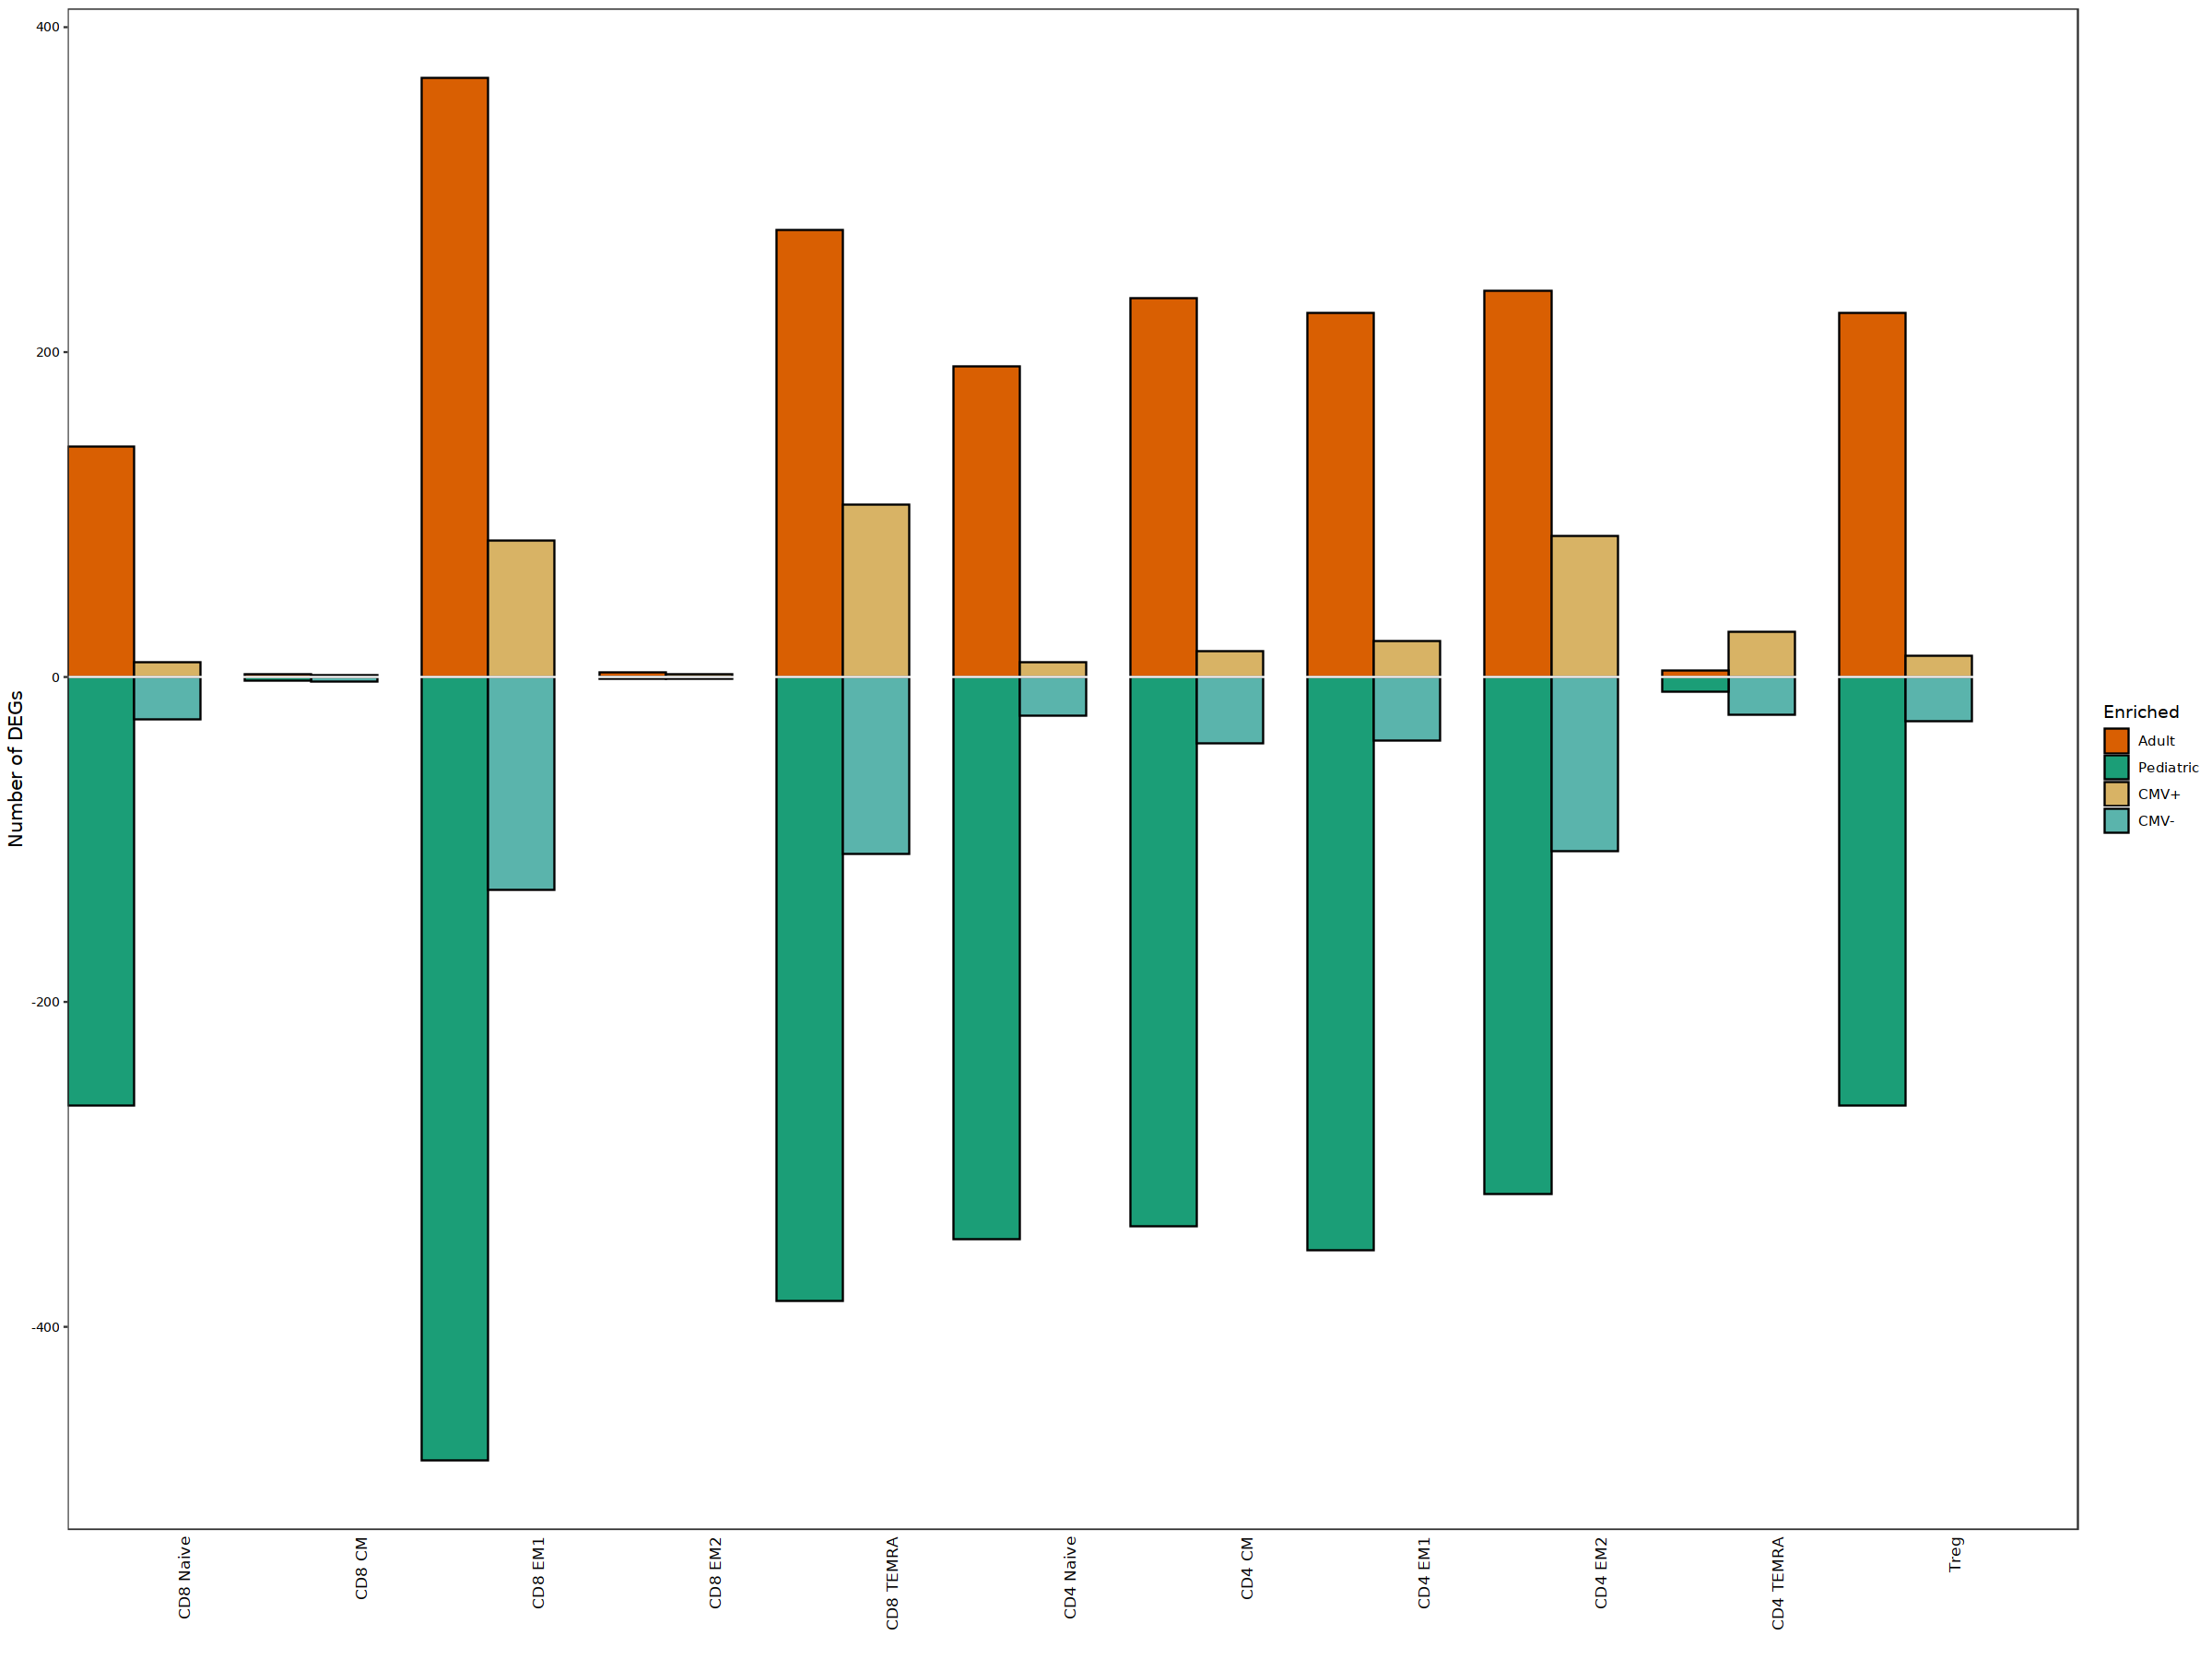

In [24]:
# plot figure 2b deg counts
p1 <- ggplot(ct_degs_counts)+ 
    geom_bar(aes(x=cluster, y=counts, fill=Enriched, group=contrast), stat="identity", width=1.5,
             color="black", position = position_dodge(preserve = "single")) +
    theme_bw() + 
    geom_hline(yintercept=0, color = 'white', size=0.5)+ 
  scale_y_continuous(breaks = seq(-2000, 1200, by = 200)) +
    ylab('Number of DEGs') +
    xlab('') +
      theme(panel.grid = element_blank(),
            axis.text.x = element_text(color = "black",
                                       size = 10,
                                       angle = 90,
                                       hjust = 1, vjust=-1),
            axis.text.y = element_text(color = "black", size = 8),
            axis.title.y = element_text(size = 12),
            axis.ticks.x = element_blank()) +
        scale_fill_manual(values =  c('#d95f02','#1b9e77', '#d8b365', '#5ab4ac'))
p1
ggsave(file.path(fig_path, paste0(proj_name, '_gating_celltype_mast_age_cmv_degs_counts_test.pdf')), 
       width = 6, height = 3)

## Fig 2e DAP couns

In [25]:
### plot the daps counts
dap_counts <- readRDS('/home/jupyter/data/PedvsSenior/combined_df_tall.rds') %>%
    mutate(Enriched=recode(comparison, 'Senior'='Adult',
                           'CMV Pos' = 'CMV+',
                           'CMV Neg' = 'CMV-'
                          ),
           celltype= factor(celltype, levels=degsct.levels))

In [26]:
dap_counts %>% head()

,celltype,contrast,comparison,sig_peaks,Enriched
,<fct>,<chr>,<fct>,<dbl>,<fct>
1,CD8 TEMRA,age,Senior,2872,Adult
2,CD4 Naive,age,Senior,11820,Adult
3,CD8 Naive,age,Senior,5161,Adult
4,CD8 EM2,age,Senior,6274,Adult
5,CD4 CM,age,Senior,5529,Adult
6,Treg,age,Senior,1233,Adult


Warning message:
“position_dodge requires non-overlapping x intervals”
Warning message:
“position_dodge requires non-overlapping x intervals”


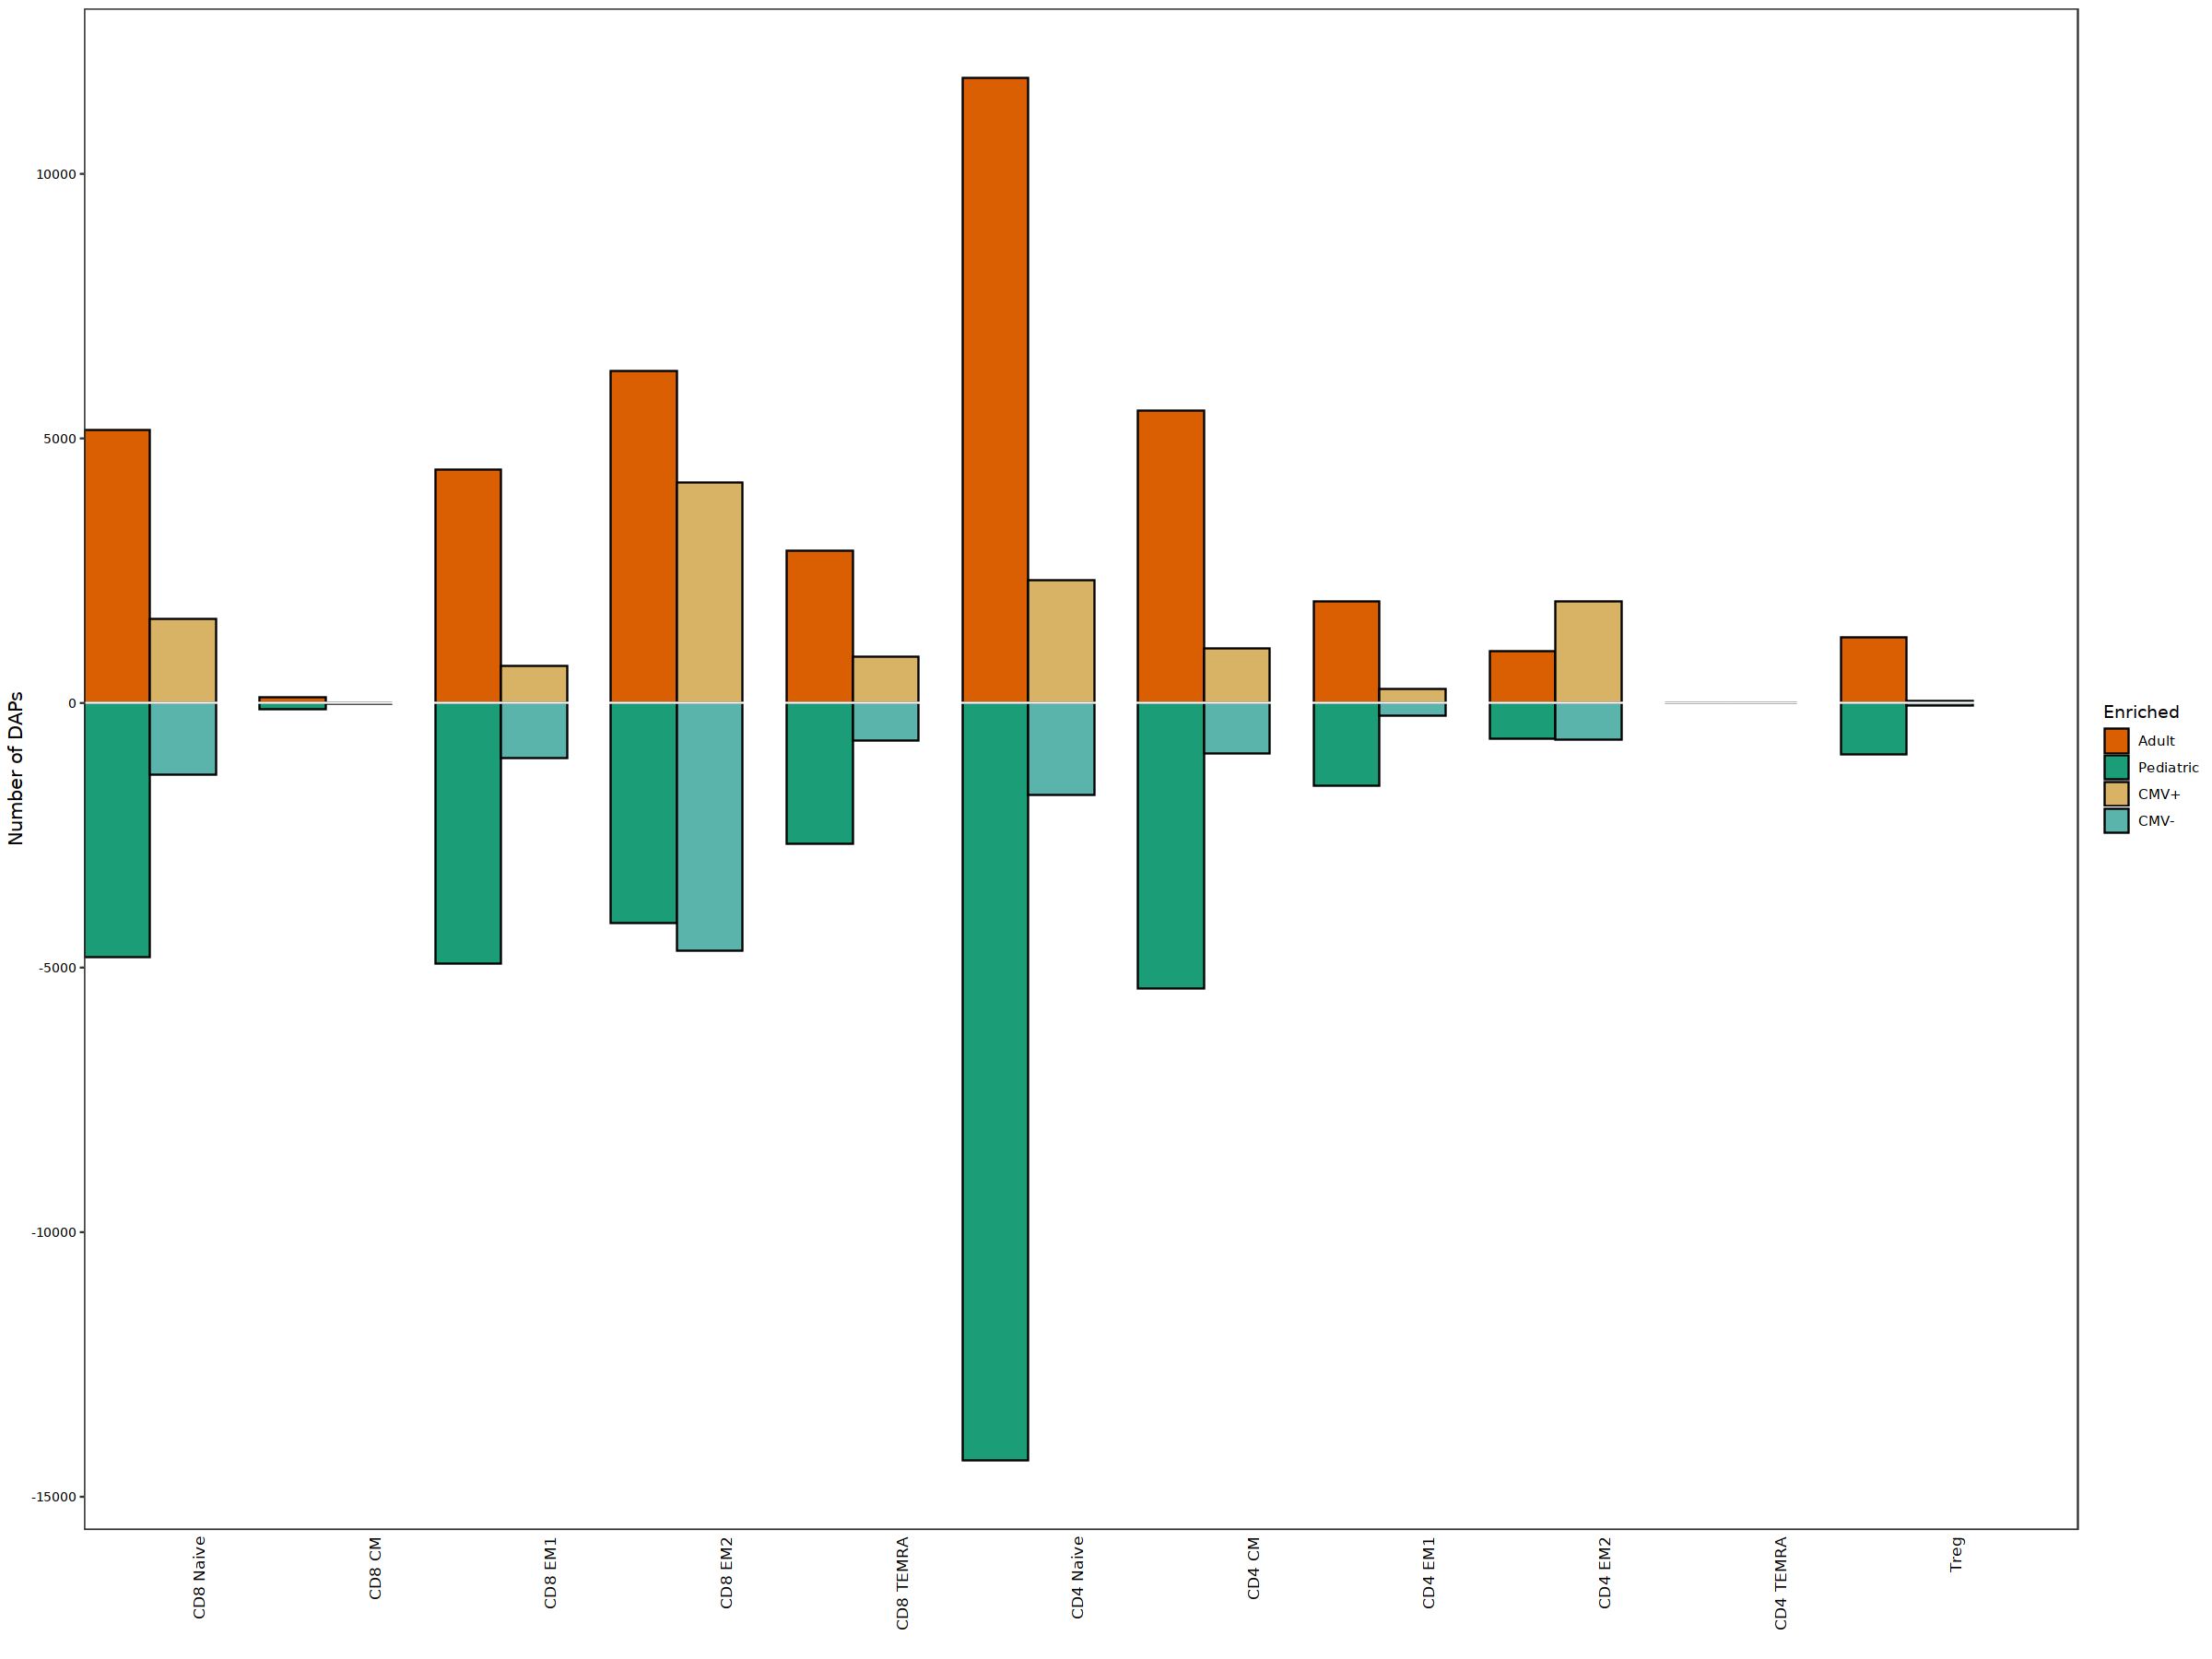

In [27]:
# figure 2b deg counts
p1 <- ggplot(dap_counts)+ 
    geom_bar(aes(x=celltype, y=sig_peaks, fill=Enriched, group=contrast), stat="identity", width=1.5,
             color="black", position = position_dodge(preserve = "single")) +
    theme_bw() + 
    geom_hline(yintercept=0, color = 'white', size=0.5)+ 
  #scale_y_continuous(breaks = seq(-2000, 1200, by = 200)) +
    ylab('Number of DAPs') +
    xlab('') +
      theme(panel.grid = element_blank(),
            axis.text.x = element_text(color = "black",
                                       size = 10,
                                       angle = 90,
                                       hjust = 1, vjust=-1),
            axis.text.y = element_text(color = "black", size = 8),
            axis.title.y = element_text(size = 12),
            axis.ticks.x = element_blank()) +
        scale_fill_manual(values =  c('#d95f02','#1b9e77', '#d8b365', '#5ab4ac'))
p1
ggsave(file.path(fig_path, paste0(proj_name, '_gating_celltype_mast_age_cmv_DAP_counts.pdf')), 
       width = 6, height = 3)

## Figure 2f Global pathway analysis by cell type

### GESA Pathway analysis by cell type
- Perform Gene Set Enrichment Analysis (GSEA) on fold-change ranked DEG list of
- adult VS young
- per age group, per celltype

In [28]:
output_path <- '/home/jupyter/data/PedvsSenior/output_results/scpa_pathways/gsea'

In [29]:
# Load and initialize pathway database
gmxFile <- "/home/jupyter/data/Reference/AT_hallmark_reactome_kegg.symbols.gmt"
colNames <- max(count.fields(file = gmxFile, sep = "\t"))
colNames <- seq(from = 1, to = colNames)
colNames <- as.character(colNames)
gmx <- read.table(file = gmxFile,
                  sep = "\t",
                  quote = "\"",
                  fill = TRUE,
                  col.names = colNames,
                  row.names = 1)
gmx <- gmx[, -1]
gmx <- apply(gmx, MARGIN = 1, FUN = function(x) {
                return(value = setdiff(unname(x), ""))
              })
names(gmx) <- toupper(names(gmx))

In [30]:
gmx %>% length()

[1] 1790

#### run gsea by logfc 

In [ ]:
# # run gsea by logfc 
pLS <- lapply(comparisons, function(cp) {
         lapply(celltypes, function(ct) {
             print(cp)
             print(ct)
             
         # create rank list based on lowest to higest gene fold-change
         rnkDF <- so_logfc %>%
                  filter(contrast == cp & celltype == ct) %>%
                  arrange(avg_log2FC)
         rnk <- as.numeric(rnkDF$avg_log2FC)
         names(rnk) <- rnkDF$gene
         print(length(rnk))
         # run GSEA by parallelization
         fgseaRes <- fgsea::fgsea(pathways = gmx,
                           stats    = rnk,
                           minSize  = 10,
                           maxSize  = 500,
                           BPPARAM  = param)
                           
         # filter on pathways <0.05 adjusted p-value
         fgseaRes2 <- fgseaRes %>%
                      as.data.frame() %>%
                      select(pathway, pval, padj, NES, leadingEdge) %>%
                      filter(padj < 0.05) %>%
                      arrange(desc(NES)) %>%
                      mutate(celltype = ct,
                             contrast = cp)
         return(value = fgseaRes2)
     })
 })

pathwayDF <- do.call(rbind, lapply(pLS, function(x) do.call(rbind, x)))
pathwayDF$leadingEdge <- vapply(pathwayDF$leadingEdge,
                                paste,
                                collapse = ", ",
                                character(1L))


In [31]:
# filter the gene list
gating_ct_degs_fl <- gating_ct_degs %>% 
    filter(Converged_C==TRUE & Converged_D==TRUE & !is.na(logFC)) 
gating_ct_degs_fl %>% head()

primerid,contrast,nomP,logFC,adjP,adjP_method,Converged_C,Converged_D,cluster_col,cluster,direction,cell_counts
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<chr>,<fct>,<chr>,<dbl>
FMN1,CMVPositive,2.751857e-02,0.6772149,7.680773e-02,BH,TRUE,TRUE,gating_celltype,CD4 CM,Up,48140
AC139720.1,pediatric_seniorSenior,3.913586e-09,0.6426050,3.052597e-07,BH,TRUE,TRUE,gating_celltype,CD4 CM,Up,48140
ST8SIA1,CMVPositive,7.037763e-05,0.6373972,6.317036e-04,BH,TRUE,TRUE,gating_celltype,CD4 CM,Up,48140
MDFIC,pediatric_seniorSenior,1.817236e-10,0.5861819,3.890432e-08,BH,TRUE,TRUE,gating_celltype,CD4 CM,Up,48140
AL589693.1,pediatric_seniorSenior,3.504842e-08,0.5096247,1.595734e-06,BH,TRUE,TRUE,gating_celltype,CD4 CM,Up,48140
NR3C2,pediatric_seniorSenior,5.886132e-11,0.4839783,1.600710e-08,BH,TRUE,TRUE,gating_celltype,CD4 CM,Up,48140


In [ ]:
# # run gsea by logfc from mast
# RUN GSEA per celltype
comparisons <- unique(gating_ct_degs_fl$contrast)
celltypes <- unique(gating_ct_degs_fl$cluster)

pLS <- lapply(comparisons, function(cp) {
         lapply(celltypes, function(ct) {
             print(cp)
             print(ct)
             
         # create rank list based on lowest to higest gene fold-change
         rnkDF <- gating_ct_degs_fl %>%
                  filter(contrast == cp & cluster == ct) %>%
                  arrange(logFC)
         rnk <- as.numeric(rnkDF$logFC)
         names(rnk) <- rnkDF$primerid
         print(length(rnk))
         # run GSEA by parallelization
         fgseaRes <- fgsea::fgsea(pathways = gmx,
                           stats    = rnk,
                           minSize  = 10,
                           maxSize  = 500,
                           BPPARAM  = param)
                           
         # filter on pathways <0.05 adjusted p-value
         fgseaRes2 <- fgseaRes %>%
                      as.data.frame() %>%
                      select(pathway, pval, padj, NES, leadingEdge) %>%
                      filter(padj < 0.05) %>%
                      arrange(desc(NES)) %>%
                      mutate(celltype = ct,
                             contrast = cp)
         return(value = fgseaRes2)
     })
 })

pathwayDF <- do.call(rbind, lapply(pLS, function(x) do.call(rbind, x)))
pathwayDF$leadingEdge <- vapply(pathwayDF$leadingEdge,
                                paste,
                                collapse = ", ",
                                character(1L))


In [ ]:
write_csv(pathwayDF, file.path(output_path, paste0(proj_name, "_GSEA_Pathways_DEGs_gating_cell_type.csv")))

In [ ]:
pathwayDF %>% 
    mutate(direction = ifelse(NES > 0, "up", "down")) %>%
    filter(padj< 0.05& NES > 0& contrast=='pediatric_seniorSenior') 

#### plot enriched pathway

In [34]:
# load the pathway results
pathwayDF <- read_csv('/home/jupyter/data/PedvsSenior/output_results/scpa_pathways/gsea/Teaseq_PedvsSenior_GSEA_Pathways_pseudobulk_DEGs_gating_cell_type.csv',
                      show_col_types = FALSE) %>% 
    mutate(direction = ifelse(NES > 0, "up", "down"))

In [35]:
pathwayDF %>% pull(padj) %>% summary()

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000681 0.009442 0.014900 0.027130 0.049985 

In [36]:
# count the pathway that are shared by many cell types in age or cmv
age_shared_pws <- pathwayDF %>% filter(padj<0.05&contrast=='pediatric_seniorSenior') %>%  group_by(pathway) %>% 
    mutate(shared_celltypes = n()) %>% arrange(desc(shared_celltypes), pathway)
# age_shared_pws %>% write_csv(file.path(output_path, paste0(proj_name, 
#                                                            "_GSEA_Pathways_pediatricVSsenior_gating_cell_type_pseudobulk_DEGs_share_sig.csv")))
age_shared_pws%>% distinct(pathway, shared_celltypes)%>% head()
# count the pathway that are shared by many cell types in cmv
cmv_shared_pws <- pathwayDF %>% filter(padj<0.05&contrast=='CMVPositive') %>%  group_by(pathway) %>% 
    mutate(shared_celltypes = n()) %>% arrange(desc(shared_celltypes), pathway)
# cmv_shared_pws %>% write_csv(file.path(output_path, 
#                                        paste0(proj_name, 
#                                               "_GSEA_Pathways_CMV_gating_cell_pseudobulk_DEGs_type_share_sig.csv")))

cmv_shared_pws %>% distinct(pathway, shared_celltypes) %>% head()

pathway,shared_celltypes
<chr>,<int>
HALLMARK_MYC_TARGETS_V1,10
REACTOME_MRNA_SPLICING,10
REACTOME_PROCESSING_OF_CAPPED_INTRON_CONTAINING_PRE_MRNA,10
REACTOME_HIV_INFECTION,9
REACTOME_METABOLISM_OF_RNA,9
REACTOME_RRNA_MODIFICATION_IN_THE_NUCLEUS_AND_CYTOSOL,9


pathway,shared_celltypes
<chr>,<int>
HALLMARK_MYC_TARGETS_V1,7
REACTOME_METABOLISM_OF_RNA,7
HALLMARK_TNFA_SIGNALING_VIA_NFKB,6
REACTOME_GENERATION_OF_SECOND_MESSENGER_MOLECULES,5
REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL,5
HALLMARK_ALLOGRAFT_REJECTION,4


In [37]:
# make plotting data frame
plotDF <- pathwayDF %>%
          #filter(pathway %in% pOrder) %>%
          mutate(group = ifelse(NES > 0, "up", "down"),
                 pID = c(1:length(pathway))) %>%
          group_by(pID) %>%
          mutate(lesize = length(unlist(strsplit(leadingEdge, ",")))) %>%
          as_tibble()

 
# determine pathway size
gsSize <- data.frame(gsize = sapply(gmx, function(x) length(x))) %>%
          rownames_to_column(var = "pathway") 

# calculate propotion of genes enriched (#leading edge genes/size of pathway)
plotDF <- plotDF %>%
          mutate(gsize = gsSize$gsize[match(pathway,
                                            table = gsSize$pathway)],
                 propGenes = (lesize/gsize)*100)

plotDF$comparisons <- factor(plotDF$contrast,
                          levels = c("pediatric_seniorSenior", "CMVPositive"))

In [41]:
age_shared_pws %>% select(-leadingEdge) %>% head()

pathway,pval,padj,NES,celltype,contrast,direction,shared_celltypes
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
HALLMARK_MYC_TARGETS_V1,2.427611e-12,2.160574e-09,-2.485747,CD4 CM,pediatric_seniorSenior,down,10
HALLMARK_MYC_TARGETS_V1,3.847415e-11,1.710176e-08,-2.390514,CD4 EM1,pediatric_seniorSenior,down,10
HALLMARK_MYC_TARGETS_V1,8.561358e-10,3.073993e-07,-2.268608,CD4 EM2,pediatric_seniorSenior,down,10
HALLMARK_MYC_TARGETS_V1,1.890554e-11,1.684484e-08,-2.360731,CD4 Naive,pediatric_seniorSenior,down,10
HALLMARK_MYC_TARGETS_V1,2.385871e-06,3.535066e-04,-1.976365,CD8 CM,pediatric_seniorSenior,down,10
HALLMARK_MYC_TARGETS_V1,1.580176e-08,7.039682e-06,-2.157139,CD8 EM1,pediatric_seniorSenior,down,10


In [42]:
age_shared_pws %>% filter(direction=='up'&shared_celltypes>=2) %>% select(pathway, direction, shared_celltypes) %>%
    distinct(pathway, .keep_all = TRUE)
cmv_shared_pws %>% filter(direction=='up'&shared_celltypes>=4) %>% select(pathway, direction, shared_celltypes) %>%
    distinct(pathway, .keep_all = TRUE)

pathway,direction,shared_celltypes
<chr>,<chr>,<int>
REACTOME_CLASS_A_1_RHODOPSIN_LIKE_RECEPTORS_,up,7
REACTOME_GPCR_LIGAND_BINDING,up,7
KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION,up,6
KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION,up,5
HALLMARK_COAGULATION,up,2
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,up,2
HALLMARK_IL2_STAT5_SIGNALING,up,2
KEGG_AUTOIMMUNE_THYROID_DISEASE,up,2
REACTOME_RIPK1_MEDIATED_REGULATED_NECROSIS,up,2


pathway,direction,shared_celltypes
<chr>,<chr>,<int>
REACTOME_GENERATION_OF_SECOND_MESSENGER_MOLECULES,up,5
REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL,up,5
HALLMARK_ALLOGRAFT_REJECTION,up,4
KEGG_GRAFT_VERSUS_HOST_DISEASE,up,4


In [43]:
age_pw_select <- age_shared_pws %>% filter(shared_celltypes>=6) %>% select(pathway, direction, shared_celltypes) %>%
    distinct(pathway, .keep_all = TRUE) %>% pull(pathway) %>%
    append(c('KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION','HALLMARK_IL2_STAT5_SIGNALING',
             'KEGG_AUTOIMMUNE_THYROID_DISEASE'))
cmv_pw_select <- cmv_shared_pws %>% filter(shared_celltypes>=3) %>% select(pathway, direction, shared_celltypes) %>%
    distinct(pathway, .keep_all = TRUE) %>% pull(pathway) 

In [ ]:
# # filter pathways to plot
# age_pw_select <- c('HALLMARK_MYC_TARGETS_V1','REACTOME_GPCR_LIGAND_BINDING','KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION',
#                   ) %>% str_remove("HALLMARK_|KEGG_|REACTOME_")
# cmv_pw_select <- c('KEGG_CELL_ADHESION_MOLECULES_CAMS', 'HALLMARK_MYC_TARGETS_V1', 'REACTOME_RRNA_PROCESSING',
# 'KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY','REACTOME_CELLULAR_RESPONSES_TO_EXTERNAL_STIMULI',
# 'HALLMARK_TNFA_SIGNALING_VIA_NFKB','KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY','REACTOME_INTERFERON_ALPHA_BETA_SIGNALING',
# 'REACTOME_TOLL_LIKE_RECEPTOR_9_TLR9_CASCADE','REACTOME_TOLL_LIKE_RECEPTOR_TLR1_TLR2_CASCADE')  %>% 
#     str_remove("HALLMARK_|KEGG_|REACTOME_")

In [ ]:
plotDF %>% select(-leadingEdge) %>% head()
# plotDF %>% filter(contrast=='pediatric_seniorSenior' & pathway %in% age_pw_select)

In [44]:
cmv_shared_pws %>% filter(shared_celltypes>=2) %>% select(pathway, direction, shared_celltypes) %>%
    distinct(pathway, .keep_all = TRUE)

pathway,direction,shared_celltypes
<chr>,<chr>,<int>
HALLMARK_MYC_TARGETS_V1,down,7
REACTOME_METABOLISM_OF_RNA,down,7
HALLMARK_TNFA_SIGNALING_VIA_NFKB,down,6
REACTOME_GENERATION_OF_SECOND_MESSENGER_MOLECULES,up,5
REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL,up,5
HALLMARK_ALLOGRAFT_REJECTION,up,4
KEGG_GRAFT_VERSUS_HOST_DISEASE,up,4
REACTOME_PROCESSING_OF_CAPPED_INTRON_CONTAINING_PRE_MRNA,down,4
KEGG_ALLOGRAFT_REJECTION,up,3


In [45]:
plotDF %>% filter(comparisons=='CMVPositive'& pathway %in% cmv_pw_select)%>%
    filter(is.na(propGenes)|is.na(NES))

pathway,pval,padj,NES,leadingEdge,celltype,contrast,direction,group,pID,lesize,gsize,propGenes,comparisons
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<fct>


In [46]:
plotDF %>% filter(comparisons=='pediatric_seniorSenior'& 
                                      pathway %in% age_pw_select) %>% 
    mutate(pathway= str_remove(pathway, "HALLMARK_|KEGG_|REACTOME_")) %>% janitor::get_dupes(c(pathway, celltype))

No duplicate combinations found of: pathway, celltype



pathway,celltype,dupe_count,pval,padj,NES,leadingEdge,contrast,direction,group,pID,lesize,gsize,propGenes,comparisons
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<fct>


In [48]:
# plotDF_fl <- plotDF %>% 
#     filter(str_detect(pathway, 
#                       'KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY|HALLMARK_OXIDATIVE_PHOSPHORYLATION|KEGG_SPLICEOSOME|MRNA_SPLICING|TNFA' ))
# plotDF_fl %>% distinct(pathway)
# select pathway to plot in the main figure
pw_select_main <- c('KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY', 'HALLMARK_OXIDATIVE_PHOSPHORYLATION', 'REACTOME_MRNA_SPLICING',
                   'KEGG_SPLICEOSOME', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB')
plotDF_fl <- plotDF %>%  filter(pathway %in% pw_select_main) %>% 
    mutate(pathway=recode(pathway, 'KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY'='KEGG_NATURAL_KILLER_CELL\nMEDIATED_CYTOTOXICITY',
                         'HALLMARK_OXIDATIVE_PHOSPHORYLATION'='HALLMARK_OXIDATIVE\nPHOSPHORYLATION',
                         'HALLMARK_TNFA_SIGNALING_VIA_NFKB'='HALLMARK_TNFA_SIGNALING\nVIA_NFKB')) %>%
    mutate(pathway= factor(str_remove(pathway, "HALLMARK_|KEGG_|REACTOME_")),
          comparisons=factor(if_else(contrast=='pediatric_seniorSenior', 'Age', 'CMV'), levels = c('Age', 'CMV')),
          celltype=factor(celltype, levels = degsct.levels))
plotDF_fl %>% select(-leadingEdge)

pathway,pval,padj,NES,celltype,contrast,direction,group,pID,lesize,gsize,propGenes,comparisons
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<fct>
MRNA_SPLICING,4.036158e-04,3.569727e-02,-1.693625,CD4 CM,pediatric_seniorSenior,down,down,8,53,188,28.19149,Age
SPLICEOSOME,7.059817e-04,2.510471e-02,-1.703418,CD4 EM1,pediatric_seniorSenior,down,down,39,42,127,33.07087,Age
MRNA_SPLICING,1.409215e-05,1.708803e-03,-1.826538,CD4 EM1,pediatric_seniorSenior,down,down,45,55,188,29.25532,Age
OXIDATIVE PHOSPHORYLATION,1.729947e-05,1.708803e-03,-1.947485,CD4 EM1,pediatric_seniorSenior,down,down,54,41,200,20.50000,Age
MRNA_SPLICING,1.896963e-03,2.715150e-02,-1.541873,CD4 EM2,pediatric_seniorSenior,down,down,71,42,188,22.34043,Age
SPLICEOSOME,1.430139e-03,2.196990e-02,-1.585926,CD4 EM2,pediatric_seniorSenior,down,down,77,42,127,33.07087,Age
OXIDATIVE PHOSPHORYLATION,8.882361e-06,5.276122e-04,-1.932129,CD4 EM2,pediatric_seniorSenior,down,down,119,46,200,23.00000,Age
MRNA_SPLICING,1.916946e-04,2.439998e-02,-1.723223,CD4 Naive,pediatric_seniorSenior,down,down,153,56,188,29.78723,Age
OXIDATIVE PHOSPHORYLATION,1.922331e-03,2.998162e-02,-1.666992,CD8 CM,pediatric_seniorSenior,down,down,177,36,200,18.00000,Age


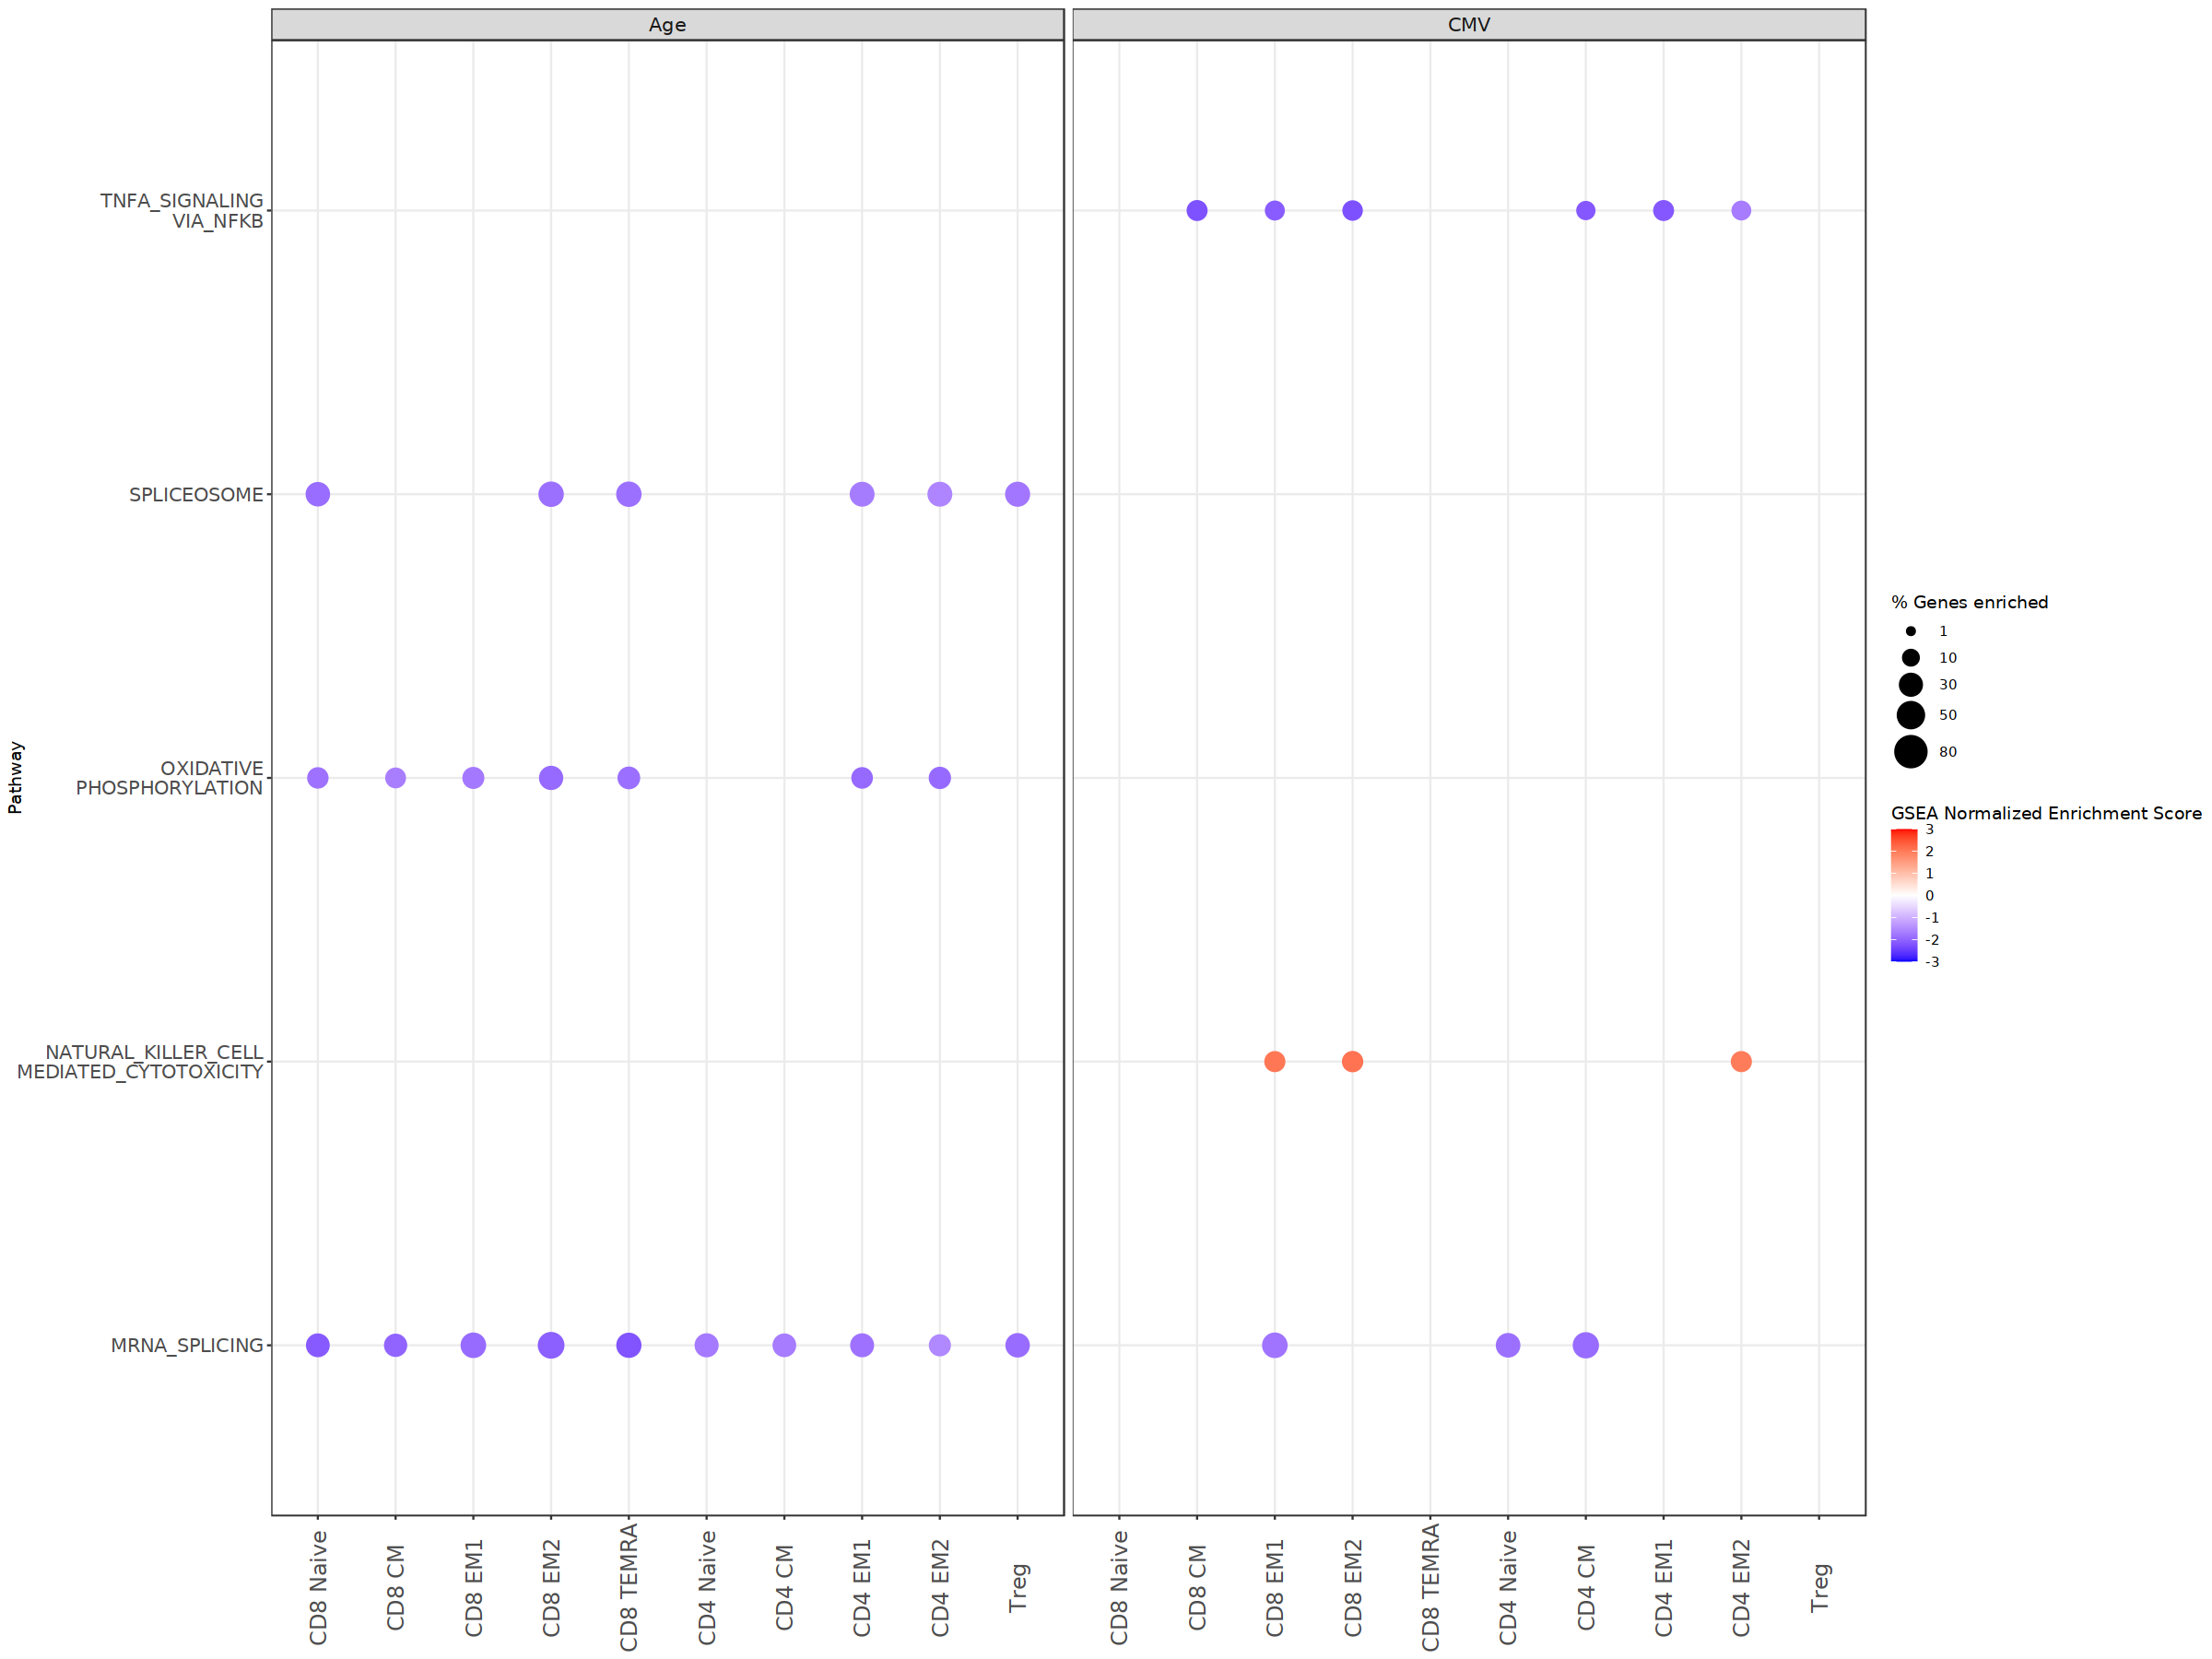

In [49]:
# making a dot plot for the pathways for the main fig
p1 <- ggplot(data = plotDF_fl ,
                mapping = aes(x = celltype, y = pathway)) +
         geom_point(aes(color = NES, size = propGenes))+  
    scale_color_gradientn(colors = c("blue", "white", "red"),
                                limit = c(-3,3)
                         ) +    theme_bw()+
    theme(plot.title = element_text(hjust = 0.5),
          axis.text.x = element_text(angle=90, vjust = 0.5, size=14),
          axis.text.y = element_text(size=12),
         strip.text.x = element_text(size = 12)) +
         scale_size(range = c(2,10),
                    limit = c(1,100),
                     breaks = c(1,10, 30, 50, 80)) +
    facet_wrap(vars(comparisons))+
    labs(title = NULL,
         x = NULL,
              y = "Pathway",
              color = "GSEA Normalized Enrichment Score",
              size = "% Genes enriched") 
p1
ggsave(file.path(fig_path, paste0(proj_name, '_combine_age_cmv_GSEA_pathways_selected_main.pdf')), 
       width=10, height=5)

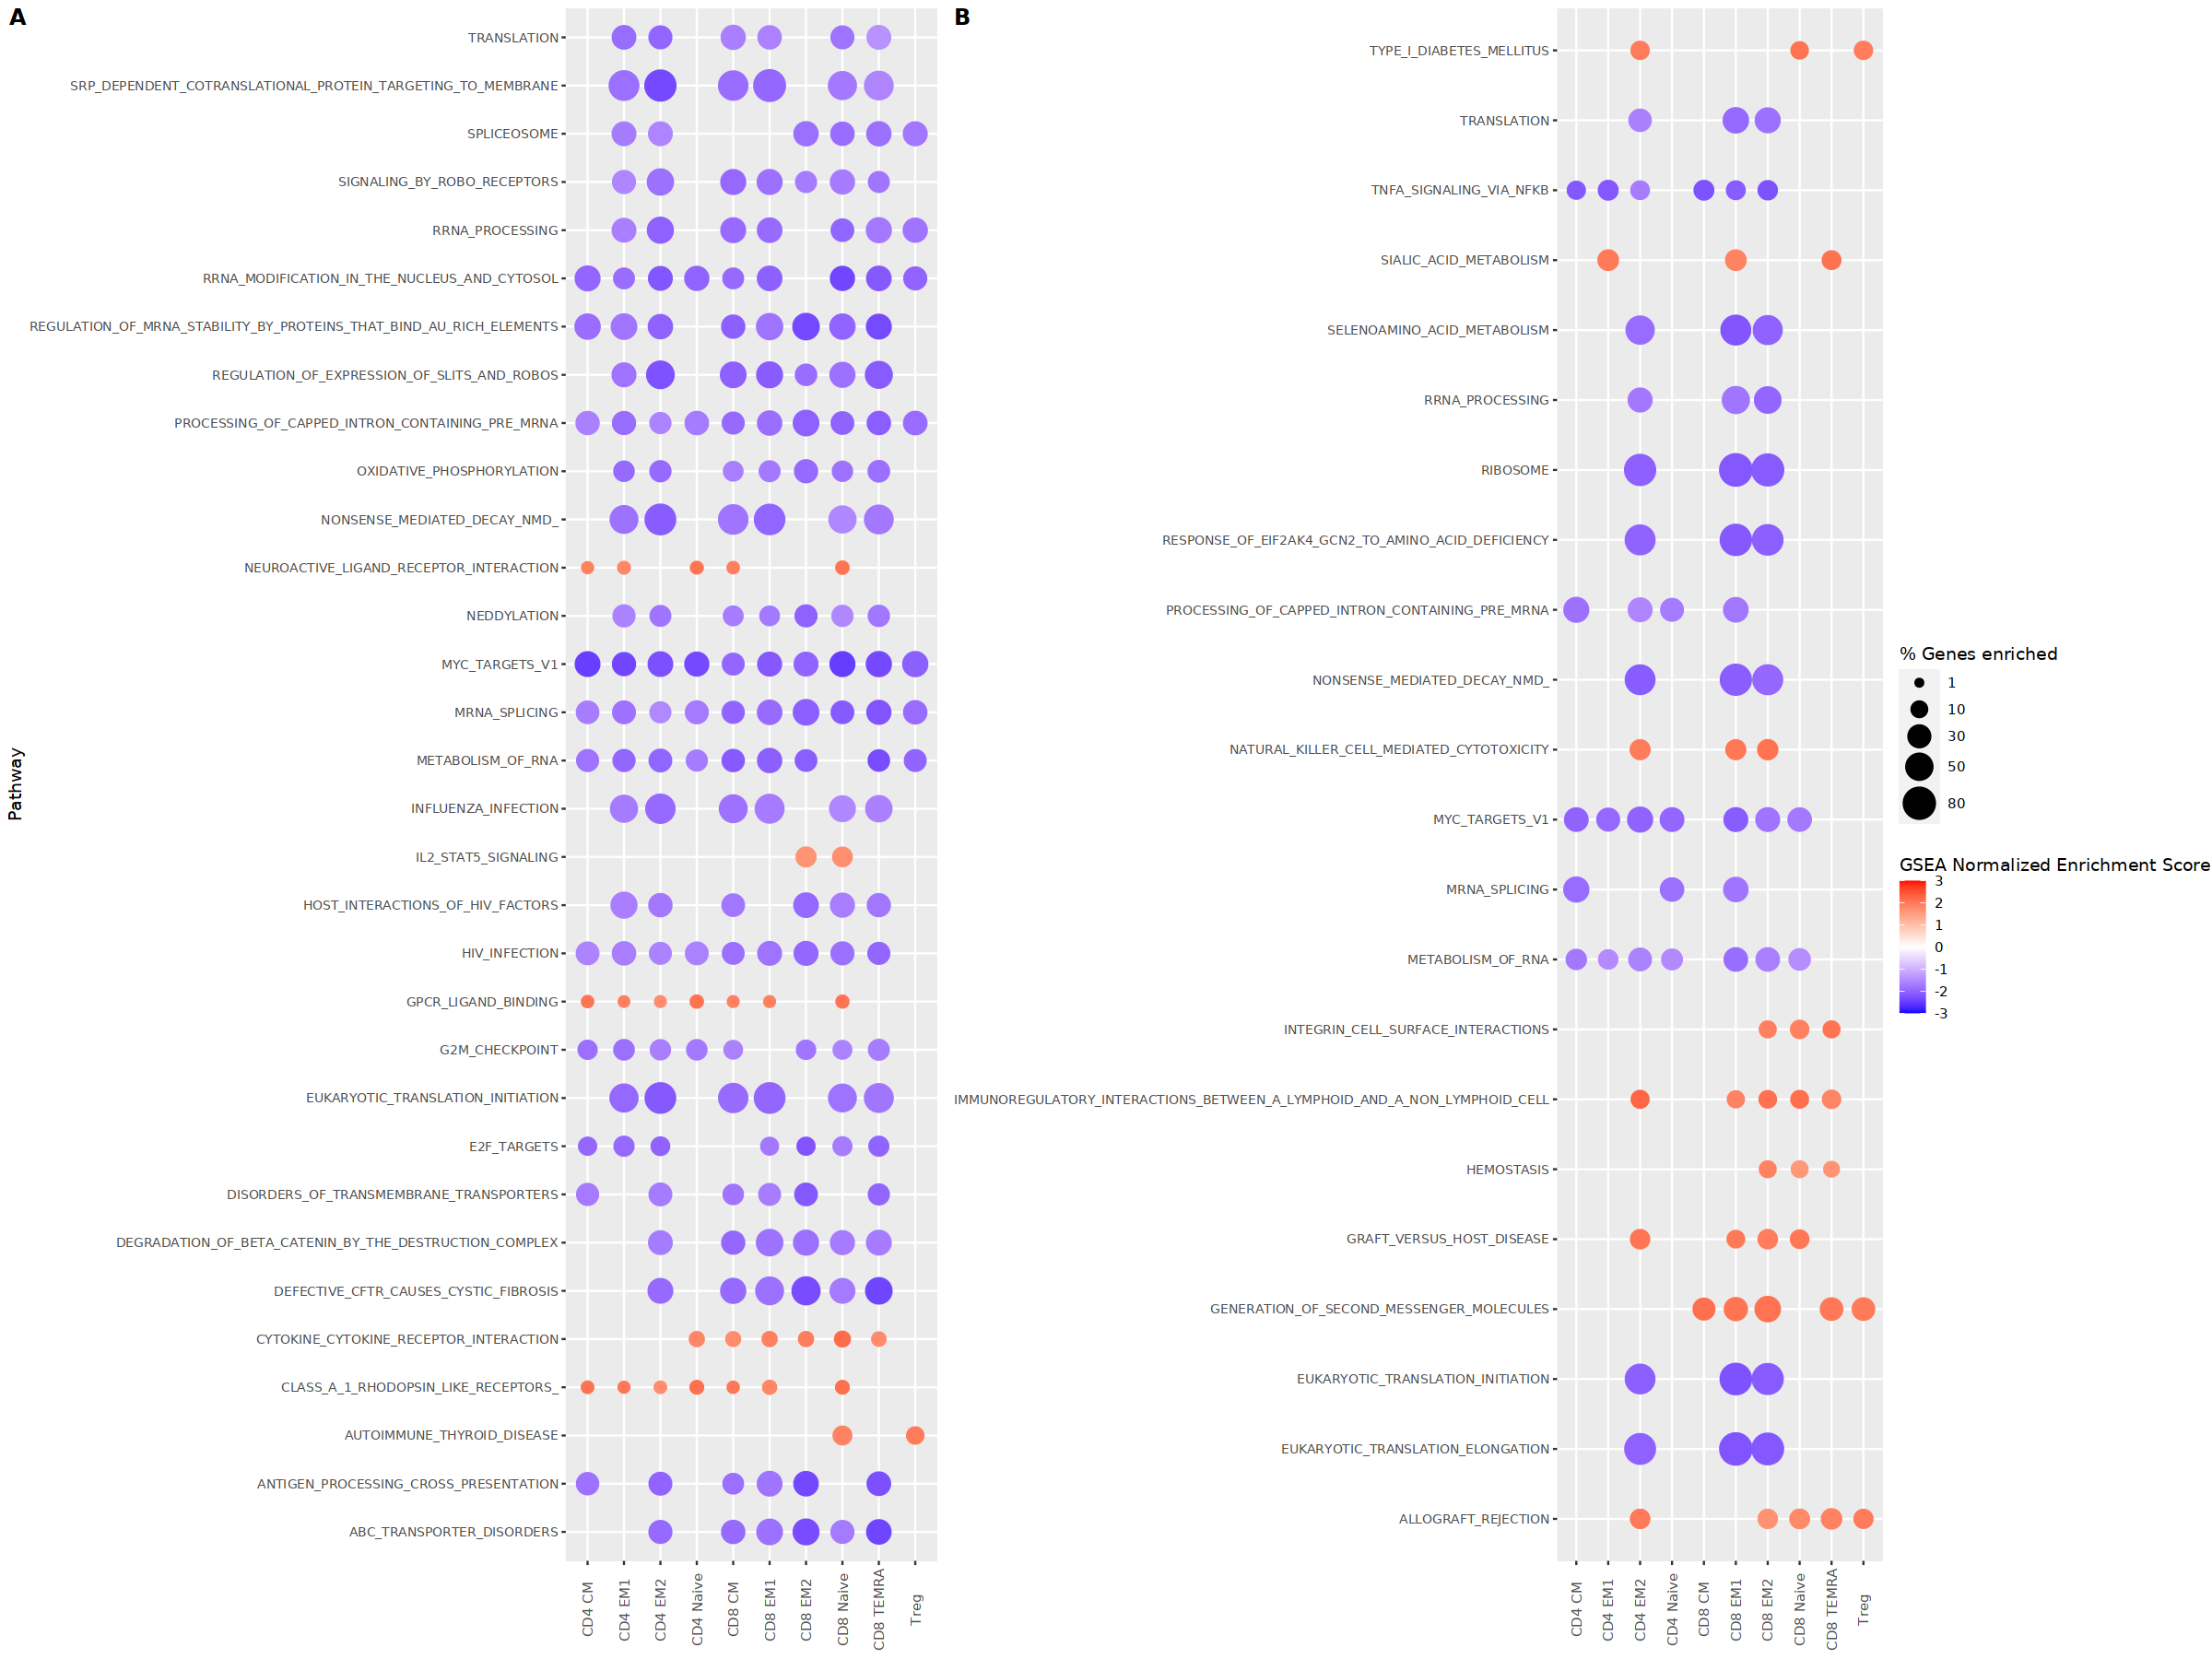

In [50]:
# making a dot plot for the pathways
p1 <- ggplot(data = plotDF %>% filter(comparisons=='pediatric_seniorSenior'& 
                                      pathway %in% age_pw_select)%>% 
    mutate(pathway= str_remove(pathway, "HALLMARK_|KEGG_|REACTOME_")),
                mapping = aes(x = celltype, y = pathway)) +
         geom_point(aes(color = NES, size = propGenes))+  
    scale_color_gradientn(colors = c("blue", "white", "red"),
                                limit = c(-3,3)
                         ) +
    theme(plot.title = element_text(hjust = 0.5),
          axis.text.x = element_text(angle=90, vjust = 0.5),
          axis.text.y = element_text(
                           size=8)) +
         scale_size(range = c(2,10),
                    limit = c(1,100),
                     breaks = c(1,10, 30, 50, 80)) +
    labs(title = NULL,
         x = NULL,
              y = "Pathway",
              color = "GSEA Normalized Enrichment Score",
              size = "% Genes enriched") 
p2 <- ggplot(data = plotDF %>% filter(comparisons=='CMVPositive'& pathway %in% cmv_pw_select)%>% 
    mutate(pathway= str_remove(pathway, "HALLMARK_|KEGG_|REACTOME_")),
                mapping = aes(x = celltype, y = pathway)) +
         geom_point(aes(color = NES, size = propGenes))+  
    scale_color_gradientn(colors = c("blue", "white", "red"),
                                limit = c(-3,3))+
    theme(plot.title = element_text(hjust = 0.5),
          axis.text.x = element_text(angle=90, vjust = 0.5),
          axis.text.y = element_text(
                           size=8)) +
         scale_size(range = c(2,10),
                        limit = c(1,100),
                    breaks = c(1,10, 30, 50, 80)) +
    labs(title = NULL, x = NULL, y = NULL)
ggpubr::ggarrange(p1, p2,common.legend = TRUE, legend = 'right', labels='AUTO')
ggsave(file.path(fig_path, paste0(proj_name, '_combine_age_cmv_GSEA_pathways_selected.pdf')), 
       width=24, height=16)